## Predicting the cost of health insurance for a person

The important insurance company 4Geeks Insurance S.L. wants to calculate, based on the physiological data of its customers what will be the premium (cost) to be borne by each of them. To do this, it has assembled a whole team of doctors, and based on data from other companies and a particular study, it has managed to gather a set of data to train a predictive model.

### Step 0: Import Libreries

In [1]:
# Libreries
import pandas as pd

# When you work locally it is likely to have an error with the SSL certification
# Recomend use request for read csv
import requests
from io import StringIO

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing  import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import (SelectKBest, 
                                       f_regression)


### Step 1: Get Data Base

In [ ]:
# Import DB
url = "https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv"
response = requests.get(url)
data = pd.read_csv(StringIO(response.text))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [3]:
# Create DB file in data/raw
data.to_csv("../data/raw/example.csv", index= False)

### Step 2: Preprocessing

In [4]:
# Delete duplicates
df_raw = data
df_raw = df_raw.drop_duplicates().reset_index(drop= True)
df_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB


In [6]:
# Scalering data
df_raw['sex_n'] = pd.factorize(df_raw['sex'])[0]
df_raw['smoker_n'] = pd.factorize(df_raw['smoker'])[0]
df_raw['region_n'] = pd.factorize(df_raw['region'])[0]
num_variables = ['age', 'bmi', 'children', 'sex_n', 'smoker_n', 'region_n', 'charges']

scaler = MinMaxScaler()
scal_features = scaler.fit_transform(df_raw[num_variables])
df_raw_scal = pd.DataFrame(scal_features, index= df_raw.index, columns= num_variables)
df_raw_scal.head()

,age,bmi,children,sex_n,smoker_n,region_n,charges
0,0.021739,0.321227,0.0,0.0,0.0,0.000000,0.251611
1,0.000000,0.479150,0.2,1.0,1.0,0.333333,0.009636
2,0.217391,0.458434,0.6,1.0,1.0,0.333333,0.053115
3,0.326087,0.181464,0.0,1.0,1.0,0.666667,0.333010
4,0.304348,0.347592,0.0,1.0,1.0,0.666667,0.043816


In [7]:
df_raw_scal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   float64
 1   bmi       1337 non-null   float64
 2   children  1337 non-null   float64
 3   sex_n     1337 non-null   float64
 4   smoker_n  1337 non-null   float64
 5   region_n  1337 non-null   float64
 6   charges   1337 non-null   float64
dtypes: float64(7)
memory usage: 73.2 KB


### Setp 3: EDA

In [20]:
# Split DB
df_train, df_test = train_test_split(df_raw, test_size= 0.2, random_state= 2024)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1069 entries, 1286 to 608
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1069 non-null   int64  
 1   sex       1069 non-null   object 
 2   bmi       1069 non-null   float64
 3   children  1069 non-null   int64  
 4   smoker    1069 non-null   object 
 5   region    1069 non-null   object 
 6   charges   1069 non-null   float64
 7   sex_n     1069 non-null   int64  
 8   smoker_n  1069 non-null   int64  
 9   region_n  1069 non-null   int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 91.9+ KB


In [21]:
# Univariate analysis
display(df_train.describe().T)

,count,mean,std,min,25%,50%,75%,max
age,1069.0,39.357343,14.062444,18.0000,27.0000,39.00000,51.0000,64.00000
bmi,1069.0,30.668363,6.159991,15.9600,26.2200,30.30500,34.8000,53.13000
children,1069.0,1.101964,1.200767,0.0000,0.0000,1.00000,2.0000,5.00000
charges,1069.0,13541.821497,12334.388474,1121.8739,4753.6368,9541.69555,17043.3414,63770.42801
sex_n,1069.0,0.500468,0.500234,0.0000,0.0000,1.00000,1.0000,1.00000
smoker_n,1069.0,0.789523,0.407838,0.0000,1.0000,1.00000,1.0000,1.00000
region_n,1069.0,1.488307,1.113882,0.0000,1.0000,1.00000,2.0000,3.00000


/tmp/ipykernel_20847/691080643.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_train.hist(ax=ax)


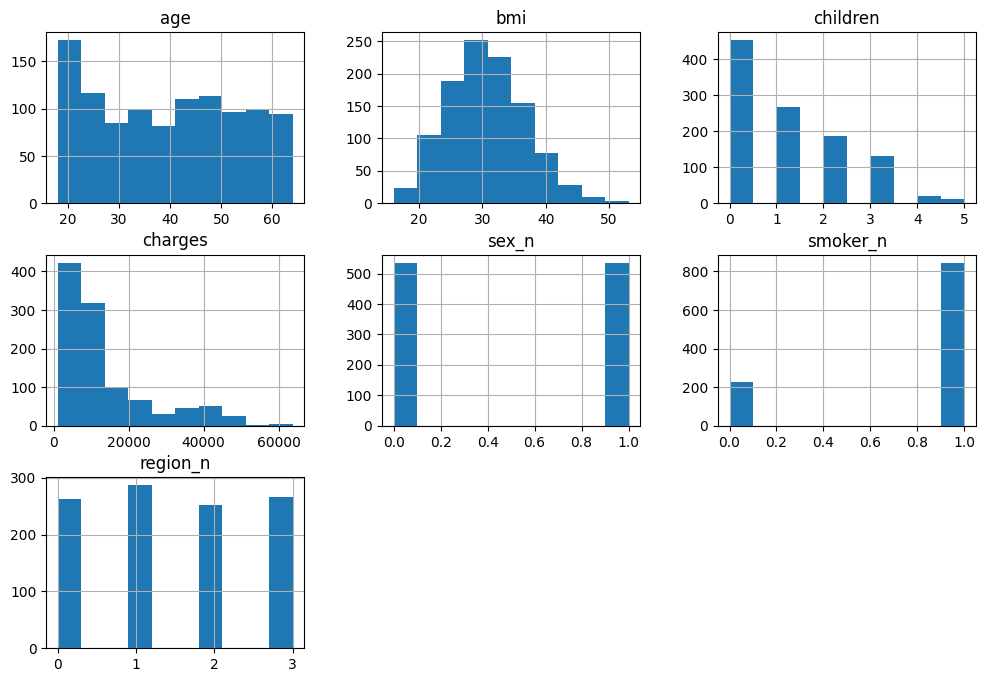

In [35]:
fig, ax = plt.subplots(figsize=(12, 8))
df_train.hist(ax=ax)
plt.show()

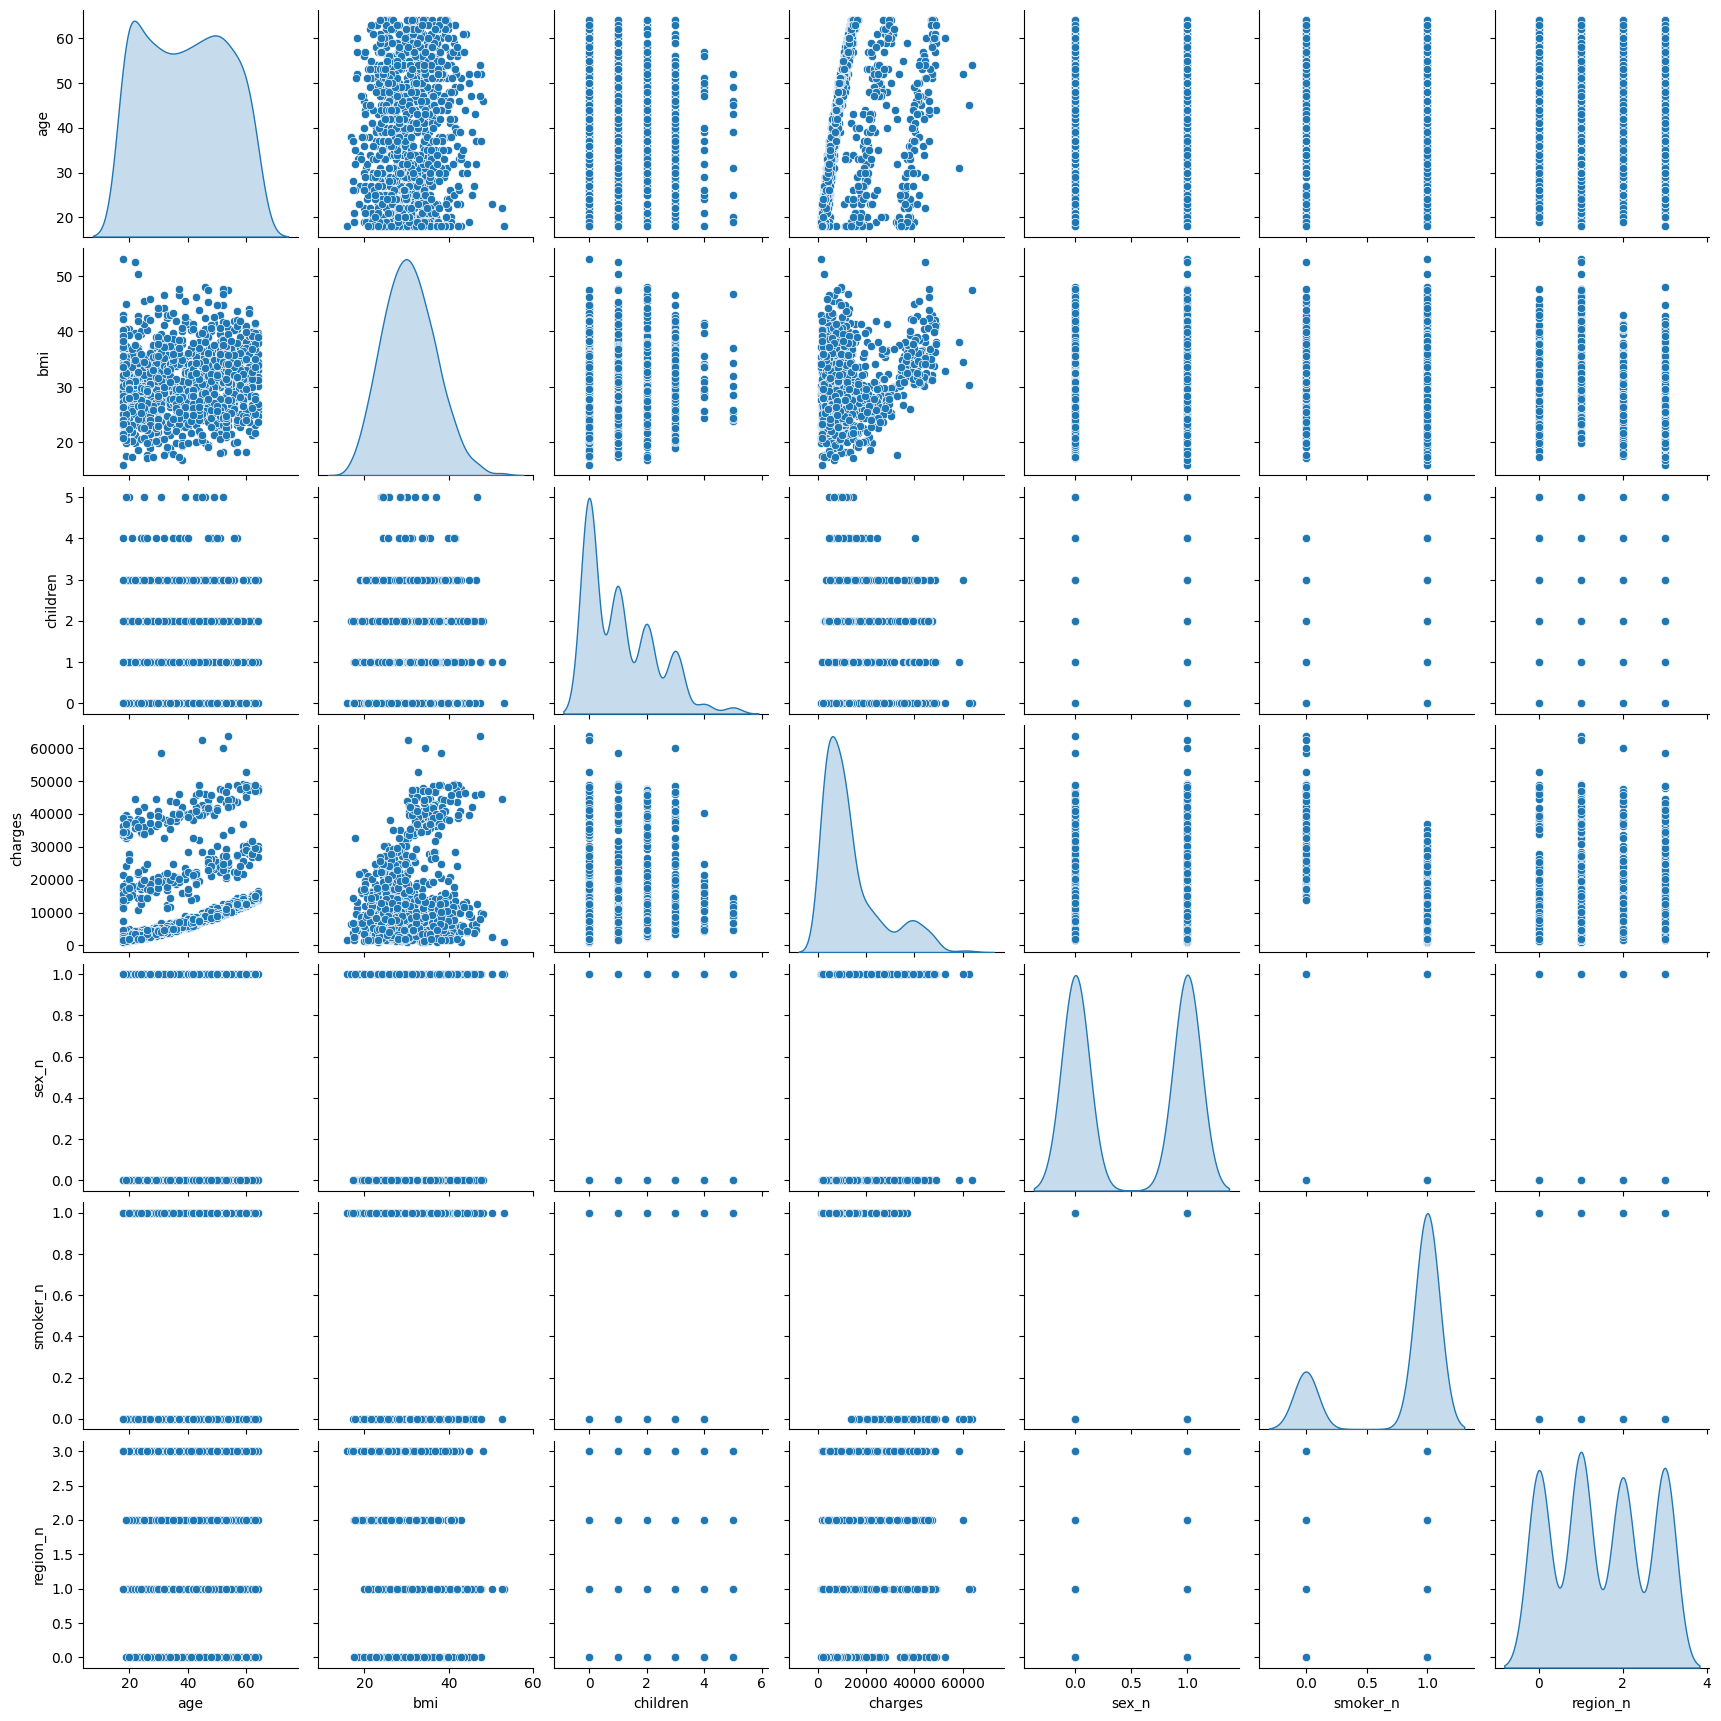

In [36]:
# Bivariate analysis
sns.pairplot(data= df_train, diag_kind="kde")
plt.show()

In [16]:
X = df_raw_scal.drop('charges', axis= 1)
y = df_raw_scal['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 2024)

select_model = SelectKBest(f_regression, k= 4)
select_model.fit(X_train, y_train)

select_columns = X_train.columns[select_model.get_support()]
X_train_sel = pd.DataFrame(select_model.transform(X_train), columns = select_columns)
X_test_sel = pd.DataFrame(select_model.transform(X_test), columns = select_columns)

In [18]:
X_train_sel.head()

,age,bmi,children,smoker_n
0,0.391304,0.267420,0.2,1.0
1,0.673913,0.439602,0.6,1.0
2,0.000000,0.562012,0.0,1.0
3,0.021739,0.127522,0.0,1.0
4,0.021739,0.496099,0.0,1.0


In [17]:
X_test_sel.head()

,age,bmi,children,smoker_n
0,0.478261,0.375034,0.4,1.0
1,0.695652,0.544525,0.0,1.0
2,0.608696,0.313156,0.0,1.0
3,0.108696,0.323917,0.0,1.0
4,0.913043,0.539279,0.0,1.0


In [19]:
# Export clean DB for train and test
X_train_sel['charges'] = y_train.values
X_test_sel['charges'] = y_test.values

X_train_sel.to_csv("../data/processed/df_clean_train.csv", index= False)
X_test_sel.to_csv("../data/processed/df_clean_test.csv", index= False)

In [23]:
display(df_train.describe(include= 'number').T)

,count,mean,std,min,25%,50%,75%,max
age,1069.0,0.464290,0.305705,0.0,0.195652,0.456522,0.717391,1.0
bmi,1069.0,0.395705,0.165725,0.0,0.276029,0.385930,0.506860,1.0
children,1069.0,0.220393,0.240153,0.0,0.000000,0.200000,0.400000,1.0
sex_n,1069.0,0.500468,0.500234,0.0,0.000000,1.000000,1.000000,1.0
smoker_n,1069.0,0.789523,0.407838,0.0,1.000000,1.000000,1.000000,1.0
region_n,1069.0,0.496102,0.371294,0.0,0.333333,0.333333,0.666667,1.0
charges,1069.0,0.198248,0.196882,0.0,0.057970,0.134398,0.254139,1.0
